# 1. Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 2. Get MNIST Data

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [6]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [7]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(70000, 784))

In [9]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

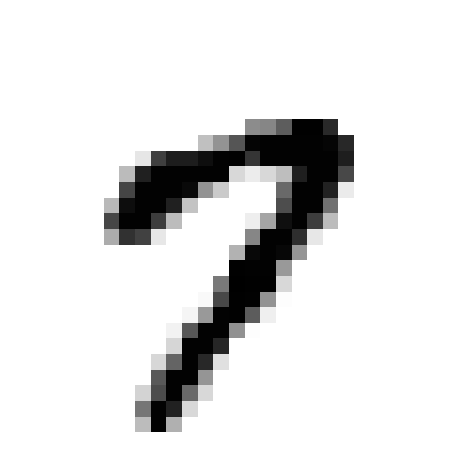

In [10]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[15]
plot_digit(some_digit)
save_fig("some_digit_plot")  # extra code
plt.show()

In [11]:
y[15]

'7'

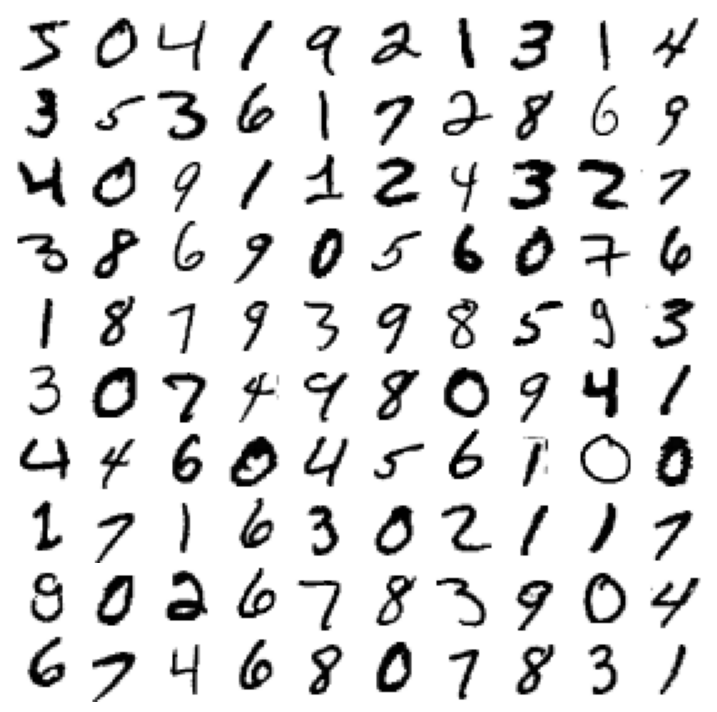

In [12]:
# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

# 3. Training Binary Classifier to Predict "7"

In [13]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
y_train_7 = (y_train == '7')
y_test_7 = (y_test == '7')

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [16]:
sgd_clf.predict([some_digit])

array([ True])

In [17]:
sgd_clf.predict([X[12]])

array([False])

# 4. Performance Measures

## 4.1. Measuring Accuracy Using Cross-Validation

In [18]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_7, cv=3, scoring="accuracy")

array([0.98105, 0.9735 , 0.95335])

In [19]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_7)
print(any(dummy_clf.predict(X_train)))

False


In [20]:
cross_val_score(dummy_clf, X_train, y_train_7, cv=3, scoring="accuracy")

array([0.8956 , 0.8956 , 0.89555])

## 4.2. Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3)

In [22]:
y_train_pred

array([False, False, False, ..., False, False, False], shape=(60000,))

In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_7, y_train_pred)
cm

array([[52581,  1154],
       [  688,  5577]])

## 4.3. Precision, Recall, and F1-Score

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_7, y_train_pred)

0.8285544495617293

In [25]:
recall_score(y_train_7, y_train_pred)

0.8901835594573024

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_7, y_train_pred)

0.858264081255771

## 4.4. Precision/Recall Trade-off

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_7, cv=3,
                             method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_7, y_scores)

In [31]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
idx = idx_for_90_precision
int(threshold_for_90_precision)

2288

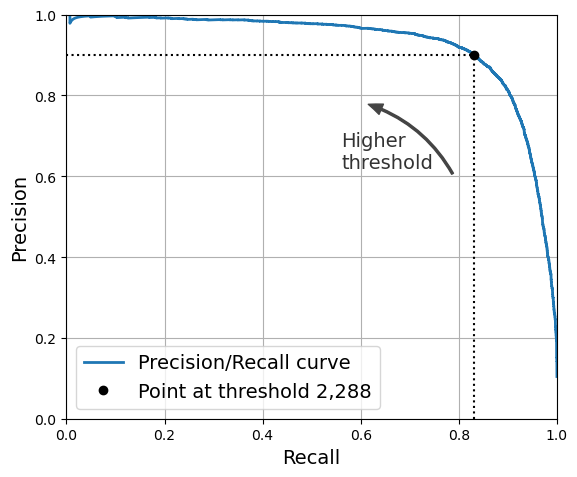

In [32]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 2,288")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [33]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [34]:
precision_score(y_train_7, y_train_pred_90)

0.9000864304235091

In [35]:
recall_at_90_precision = recall_score(y_train_7, y_train_pred_90)
recall_at_90_precision

0.8311252992817239

## 4.5. ROC Curve

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_7, y_scores)

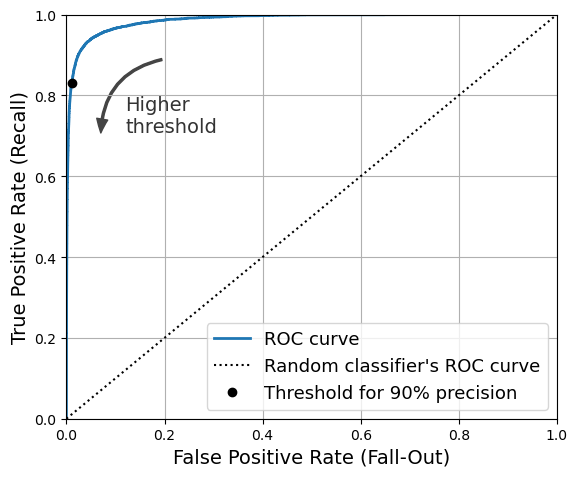

In [38]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [39]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_7, y_scores)

0.986670497551944

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [43]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_7, cv=3,
                                    method="predict_proba")
y_probas_forest[14:17]

array([[1.  , 0.  ],
       [0.02, 0.98],
       [0.96, 0.04]])

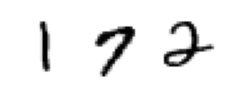

In [44]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[14:17]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [45]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_7, y_scores_forest)

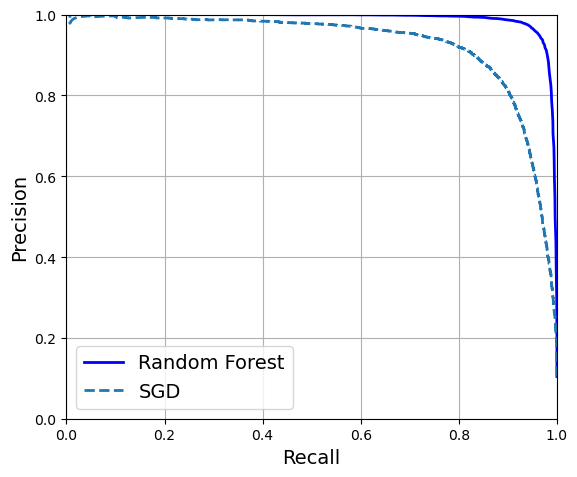

In [46]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [47]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_7, y_train_pred_forest)

0.9447353112274578

In [48]:
roc_auc_score(y_train_7, y_scores_forest)

0.9982488581790974

In [49]:
precision_score(y_train_7, y_train_pred_forest)

0.9854368932038835

In [50]:
recall_score(y_train_7, y_train_pred_forest)

0.9072625698324023